In [ ]:
data_path = 'content'
output_path = 'content'

Install Required packages and import libraries

In [ ]:
pip install transformers

In [ ]:
pip install -U torchtext==0.6.0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

Data Loading

In [ ]:
# Load CSV file with dataset. Perform basic transformations.
df = pd.read_csv("sem18(train+test)and sem22(train with data aug)+(13k).csv")

In [ ]:
df

,Unnamed: 0,tweet,sarcastic
0,0,the biggest only problem thing i got from coll...,1
1,1,the absolutely only thing i got fired from the...,1
2,2,perhaps the second only nice thing i got out f...,1
3,3,i love it when college professors randomly dra...,1
4,4,i really love it funny when professors constan...,1
...,...,...,...
19981,13551,['8-9ft man found in ancient indian burial mou...,0
19982,13552,"[""Second Scottish independence referendum 'on ...",0
19983,13553,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0
19984,13554,"['The logic here is flawless!', ""No it isn't, ...",0


Data Cleaning

In [ ]:
import re
from nltk.corpus import stopwords  ## stopwords from nltk corpus
import nltk

b = list(df["tweet"])


nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
  
    review = ' '.join(review)

    corpus.append(review)
df = df.assign(clean_tweet1 = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = df.drop_duplicates(subset=["clean_tweet1"])

Data Visualisation

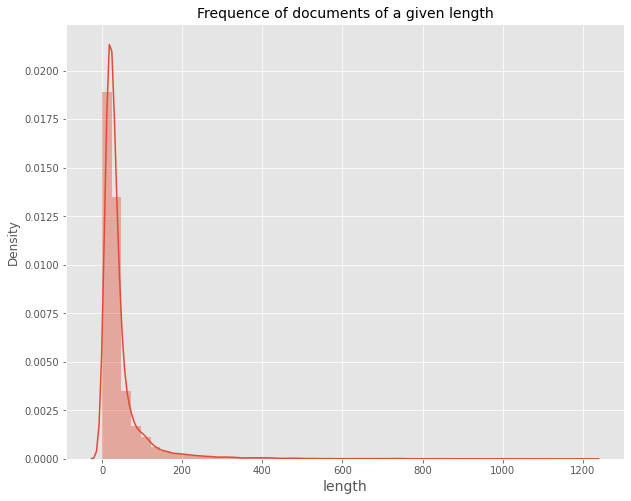

In [ ]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = df['clean_tweet1'].apply(lambda x: len(x.split()))
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [ ]:
# Save preprocessed data, cropped to max length of the model.
df['clean_tweet1'] = df['clean_tweet1'].apply(lambda x: " ".join(x.split()[:512]))
df.to_csv("prep_news.csv")

In [ ]:
import tensorflow as tf

In [ ]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

device = tf.test.gpu_device_name()
print(device)

/device:GPU:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'clean_tweet1' : ('clean_tweet1', text_field), 'sarcastic' : ('sarcastic', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path="prep_news.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='sarcastic')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.clean_tweet1), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
test_data

In [ ]:
type(test_iter)

torchtext.data.iterator.Iterator

In [ ]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base',return_dict=False)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x  

In [ ]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5,return_dict=False):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [ ]:
# Training Function

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path,return_dict=False):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint('model.pkl', model, best_valid_loss)
                    save_metrics('metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics('metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [ ]:
# Main training loop
NUM_EPOCHS = 5
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS =10
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


======================= Start pretraining ==============================
Epoch [1/5], global step [875/4375], PT Loss: 0.7181, Val Loss: 0.6907
Epoch [2/5], global step [1750/4375], PT Loss: 0.7040, Val Loss: 0.6924
Epoch [3/5], global step [2625/4375], PT Loss: 0.6968, Val Loss: 0.6919
Epoch [4/5], global step [3500/4375], PT Loss: 0.6947, Val Loss: 0.6909
Epoch [5/5], global step [4375/4375], PT Loss: 0.6934, Val Loss: 0.6910
Pre-training done!
======================= Start training =================================
Epoch [1/10], global step [875/8750], Train Loss: 0.6906, Valid Loss: 0.6808
Epoch [2/10], global step [1750/8750], Train Loss: 0.6570, Valid Loss: 0.6497
Epoch [3/10], global step [2625/8750], Train Loss: 0.6231, Valid Loss: 0.6012
Epoch [4/10], global step [3500/8750], Train Loss: 0.5779, Valid Loss: 0.5822
Epoch [5/10], global step [4375/8750], Train Loss: 0.5356, Valid Loss: 0.5676
Epoch [6/10], global step [5250/8750], Train Loss: 0.5065, Valid Loss: 0.5683
Epoch [7/

Loss Curve

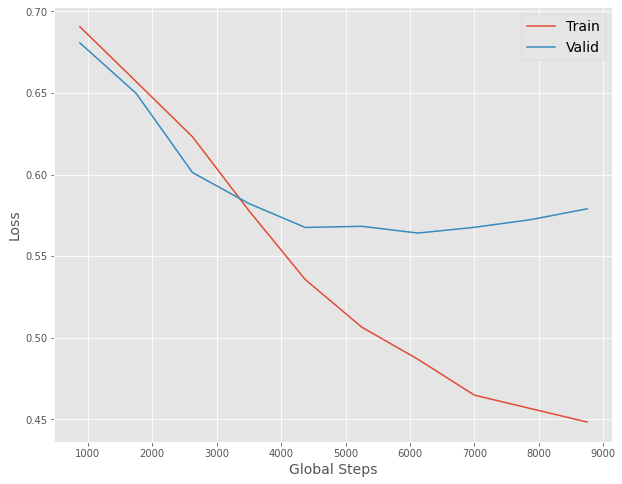

In [ ]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics('metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    print(y_pred)
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    return y_pred

In [ ]:
test_iter

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classification Report:
              precision    recall  f1-score   support

           0     0.6581    0.7969    0.7209      1901
           1     0.7723    0.6245    0.6906      2096

    accuracy                         0.7065      3997
   macro avg     0.7152    0.7107    0.7057      3997
weighted avg     0.7180    0.7065    0.7050      3997

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1

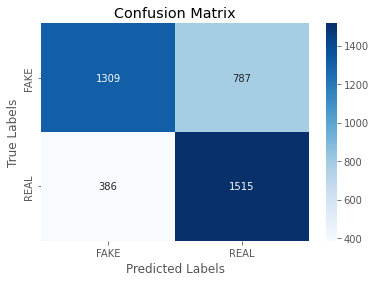

In [ ]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint('model.pkl', model)

y_pred =evaluate(model, test_iter)

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

13988
1997
3997


Prediction on test data 

In [ ]:
df1  =  pd.read_csv("taskA.En.input.csv")   # test data for Sub-Task A

In [ ]:
df1

,text
0,"Size on the the Toulouse team, That pack is mo..."
1,Pinball!
2,So the Scottish Government want people to get ...
3,villainous pro tip : change the device name on...
4,I would date any of these men 🥺
...,...
1395,I’ve just seen this and felt it deserved a Ret...
1396,Omg how an earth is that a pen !!! 🤡
1397,Bringing Kanye and drake to a tl near you
1398,"I love it when women are referred to as ""girl ..."


In [ ]:
df1 = df1.assign(ramdom_label=[1 for i in range(len(df1["text"]))])

In [ ]:
df1

,text,ramdom_label
0,"Size on the the Toulouse team, That pack is mo...",1
1,Pinball!,1
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,1
4,I would date any of these men 🥺,1
...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,1
1396,Omg how an earth is that a pen !!! 🤡,1
1397,Bringing Kanye and drake to a tl near you,1
1398,"I love it when women are referred to as ""girl ...",1


In [ ]:
df1.to_csv("abc.csv")

In [ ]:
df1

,text,ramdom_label
0,"Size on the the Toulouse team, That pack is mo...",1
1,Pinball!,1
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,1
4,I would date any of these men 🥺,1
...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,1
1396,Omg how an earth is that a pen !!! 🤡,1
1397,Bringing Kanye and drake to a tl near you,1
1398,"I love it when women are referred to as ""girl ...",1


In [ ]:
fields = {'text' : ('text', text_field), 'ramdom_label' : ('ramdom_label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
test_data = TabularDataset(path="abc.csv", format='CSV', fields=fields)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)


In [ ]:
test_data

In [ ]:
test_iter

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.1714    0.2927      1400

    accuracy                         0.1714      1400
   macro avg     0.5000    0.0857    0.1463      1400
weighted avg     1.0000    0.1714    0.2927      1400

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

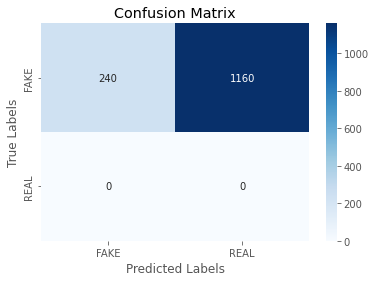

In [ ]:
model = ROBERTAClassifier()     ### Roberta classifier
model = model.to(device)

load_checkpoint('model.pkl', model)     ### checkpoint

y_pred = evaluate(model, test_iter)

In [ ]:
df1 = df1.assign(task_a_en=y_pred)

In [ ]:
df1

,text,ramdom_label,task_a_en
0,"Size on the the Toulouse team, That pack is mo...",1,1
1,Pinball!,1,0
2,So the Scottish Government want people to get ...,1,0
3,villainous pro tip : change the device name on...,1,0
4,I would date any of these men 🥺,1,0
...,...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,1,0
1396,Omg how an earth is that a pen !!! 🤡,1,0
1397,Bringing Kanye and drake to a tl near you,1,0
1398,"I love it when women are referred to as ""girl ...",1,1


In [ ]:
df1["task_a_en"].value_counts()

0    1160
1     240
Name: task_a_en, dtype: int64

In [ ]:
test_data = pd.read_csv("task_A_En_test.csv")

In [ ]:
test_data = test_data.assign(pred=y_pred)

In [ ]:
print(classification_report(test_data["sarcastic"], test_data["pred"]))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1200
           1       0.39      0.47      0.42       200

    accuracy                           0.82      1400
   macro avg       0.65      0.67      0.66      1400
weighted avg       0.83      0.82      0.83      1400



In [ ]:
import pandas as pd

In [ ]:
task_c=pd.read_csv("task_C_En_test.csv")

In [ ]:
task_c

,text_0,text_1,sarcastic_id
0,I see that your team played well today!,I'm sorry that your team didn't win yesterday.,0
1,"Anthony Taylor is such a fair referee, I wish ...",I hope Anthony Taylor is never put in charge o...,0
2,"the weather is gloomy, just raining and dull.",What a glorious weather today,1
3,People going out to get there boosters without...,Nice to see the sheep getting their boosters t...,1
4,"Really great weather we're having, love a bit ...",Really cold January so far - looking forward t...,0
...,...,...,...
195,"the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected",0
196,Cant believe we have to spend the rest of our ...,Cant wait to spend the rest of my life waiting...,1
197,Isn't it just amazing how competent the govern...,"Everything is a total mess, how can anyone be ...",0
198,Thanks Boris Johnson for restricting travel ab...,The reasoning behind the tightening of travel ...,0


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(task_c["text_0"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    TAG_RE = re.compile(r'<[^>]+>')
    review = TAG_RE.sub('', review)
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
task_c = task_c.assign(clean_text0 = corpus)


import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(task_c["text_1"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    TAG_RE = re.compile(r'<[^>]+>')
    review = TAG_RE.sub('', review)
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
task_c = task_c.assign(clean_text1 = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
task_c

,text_0,text_1,sarcastic_id,clean_text0,clean_text1
0,I see that your team played well today!,I'm sorry that your team didn't win yesterday.,0,i see that your team played well today!,i'm sorry that your team didn't win yesterday.
1,"Anthony Taylor is such a fair referee, I wish ...",I hope Anthony Taylor is never put in charge o...,0,"anthony taylor is such a fair referee, i wish ...",i hope anthony taylor is never put in charge o...
2,"the weather is gloomy, just raining and dull.",What a glorious weather today,1,"the weather is gloomy, just raining and dull.",what a glorious weather today
3,People going out to get there boosters without...,Nice to see the sheep getting their boosters t...,1,people going out to get there boosters without...,nice to see the sheep getting their boosters t...
4,"Really great weather we're having, love a bit ...",Really cold January so far - looking forward t...,0,"really great weather we're having, love a bit ...",really cold january so far - looking forward t...
...,...,...,...,...,...
195,"the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected",0,"the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected"
196,Cant believe we have to spend the rest of our ...,Cant wait to spend the rest of my life waiting...,1,cant believe we have to spend the rest of our ...,cant wait to spend the rest of my life waiting...
197,Isn't it just amazing how competent the govern...,"Everything is a total mess, how can anyone be ...",0,isn't it just amazing how competent the govern...,"everything is a total mess, how can anyone be ..."
198,Thanks Boris Johnson for restricting travel ab...,The reasoning behind the tightening of travel ...,0,thanks boris johnson for restricting travel ab...,the reasoning behind the tightening of travel ...


In [ ]:
task_c = task_c.assign(random_label=[1 for i in range(len(task_c["clean_text0"]))])


In [ ]:
task_c.to_csv("taskc.csv")

In [ ]:
task_c


,text_0,text_1,sarcastic_id,clean_text0,clean_text1,random_label
0,I see that your team played well today!,I'm sorry that your team didn't win yesterday.,0,i see that your team played well today!,i'm sorry that your team didn't win yesterday.,1
1,"Anthony Taylor is such a fair referee, I wish ...",I hope Anthony Taylor is never put in charge o...,0,"anthony taylor is such a fair referee, i wish ...",i hope anthony taylor is never put in charge o...,1
2,"the weather is gloomy, just raining and dull.",What a glorious weather today,1,"the weather is gloomy, just raining and dull.",what a glorious weather today,1
3,People going out to get there boosters without...,Nice to see the sheep getting their boosters t...,1,people going out to get there boosters without...,nice to see the sheep getting their boosters t...,1
4,"Really great weather we're having, love a bit ...",Really cold January so far - looking forward t...,0,"really great weather we're having, love a bit ...",really cold january so far - looking forward t...,1
...,...,...,...,...,...,...
195,"the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected",0,"the tories betrayed the nation, what a surprise!","the tories betrayed the nation, as expected",1
196,Cant believe we have to spend the rest of our ...,Cant wait to spend the rest of my life waiting...,1,cant believe we have to spend the rest of our ...,cant wait to spend the rest of my life waiting...,1
197,Isn't it just amazing how competent the govern...,"Everything is a total mess, how can anyone be ...",0,isn't it just amazing how competent the govern...,"everything is a total mess, how can anyone be ...",1
198,Thanks Boris Johnson for restricting travel ab...,The reasoning behind the tightening of travel ...,0,thanks boris johnson for restricting travel ab...,the reasoning behind the tightening of travel ...,1


In [ ]:
fields = {'clean_text0' : ('clean_text0', text_field), 'random_label' : ('random_label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
test_data = TabularDataset(path="taskc.csv", format='CSV', fields=fields)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
import numpy as np

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)
                logits = output.detach().cpu().numpy()
                y_pred.append(logits)
                
                flat_predictions1 = [np.max(item) for sublist in y_pred for item in sublist]
                y_true.extend(target.tolist())
    
    return flat_predictions1

In [ ]:
flat_predictions0 = evaluate(model, test_iter)

In [ ]:
flat_predictions0


[0.45541063,
 0.48650864,
 1.1256764,
 0.69310784,
 0.9375502,
 1.3258672,
 0.26321936,
 0.37940297,
 1.5495042,
 0.9608167,
 1.0711815,
 1.2713994,
 1.0726885,
 1.3897576,
 1.2103868,
 0.89132017,
 0.4512579,
 0.8857524,
 0.8557868,
 0.7974177,
 0.28495115,
 1.2091123,
 0.90040034,
 0.8392242,
 1.213188,
 0.27980968,
 0.6570378,
 1.0785333,
 0.85027975,
 1.6284723,
 0.2876015,
 0.6458939,
 0.2905928,
 0.84707844,
 0.49887457,
 1.4560463,
 0.34938827,
 0.4662154,
 0.9280158,
 1.3862231,
 1.508368,
 0.87703025,
 1.4434159,
 1.0091486,
 1.0219018,
 1.4325173,
 1.1730843,
 0.62467545,
 0.63761914,
 0.5515434,
 0.45760974,
 1.3100533,
 1.0791231,
 0.5078214,
 0.721589,
 1.418254,
 0.86482656,
 0.78433174,
 0.9433873,
 0.27024412,
 0.7610222,
 1.2371693,
 1.1951987,
 0.7470167,
 0.5551652,
 0.81071925,
 0.77270234,
 0.803604,
 0.86516494,
 1.0615743,
 1.0545979,
 0.24721241,
 1.5184503,
 1.524684,
 0.33472666,
 0.6797479,
 1.2944415,
 0.45288607,
 0.5992008,
 0.73672605,
 0.7540705,
 0.6806

In [ ]:
fields = {'clean_text1' : ('clean_text1', text_field), 'random_label' : ('random_label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
test_data1 = TabularDataset(path="taskc.csv", format='CSV', fields=fields)

# Test iterator, no shuffling or sorting required.
test_iter1 = Iterator(test_data1, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
flat_predictions1 = evaluate(model, test_iter1)

In [ ]:
len(flat_predictions0)

200

In [ ]:
task_c_en = []

In [ ]:
flat_predictions1[0]

1.1258612

In [ ]:

for i in range(200):
  if flat_predictions0[i]>flat_predictions1[i]:
    task_c_en.append(0)
  if flat_predictions0[i]<flat_predictions1[i]:
    task_c_en.append(1)
task_c_en

In [ ]:
print(classification_report(list(task_c["sarcastic_id"]), task_c_en))

              precision    recall  f1-score   support

           0       0.50      0.42      0.46       107
           1       0.44      0.52      0.47        93

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.47      0.47      0.46       200

